# Predicting Outcomes of Hockey Games

Author: Andrew Little

Course Project, UC Irvine, Math 10, S23

## Introduction

The data is from Kaggle and involves the stats like shots, goals, blocked shot, etc.. from NHL hockey games. Our goal is to see if machine learning algorithms can predict whether or not a team wins given the stats of the game and which stats are most important to the outcome.

## Importing and Cleaning Data


In [1]:
import pandas as pd 
import altair as alt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

We will upload the data and get a look at it to make sure everything uploaded successfully.

In [2]:
df_up = pd.read_csv('game_teams_stats.csv')
df_up

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,right
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52605,2018030416,19,home,False,REG,Craig Berube,1.0,29.0,29.0,20.0,4.0,0.0,58.7,12.0,11.0,9.0,right
52606,2018030417,19,away,True,REG,Craig Berube,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,21.0,right
52607,2018030417,6,home,False,REG,Bruce Cassidy,1.0,33.0,28.0,0.0,1.0,0.0,51.0,13.0,6.0,7.0,right
52608,2018030417,19,away,True,REG,Craig Berube,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,21.0,right


Now we will get rid of the columns that are uninteresting and not very useful. Then we want to check for NA values to make sure that the data can be used.

In [3]:
df = df_up.drop(['head_coach', 'startRinkSide', 'game_id'], axis=1)
df.isna().sum(axis=0)

team_id                       0
HoA                           0
won                           0
settled_in                    0
goals                         8
shots                         8
hits                       4928
pim                           8
powerPlayOpportunities        8
powerPlayGoals                8
faceOffWinPercentage      22148
giveaways                  4928
takeaways                  4928
blocked                    4928
dtype: int64

There is a lot of missing data in the faceoff win percentage so I manually checked the data frame and the data seems to be missing from older games which can be checked by the game i.d. (The first four digits in game_id are the year). Also I do not want any shootout games so we will only keep games ending in REG and OT

In [4]:
df.dropna(inplace=True)
df.isna().sum(axis=0)

team_id                   0
HoA                       0
won                       0
settled_in                0
goals                     0
shots                     0
hits                      0
pim                       0
powerPlayOpportunities    0
powerPlayGoals            0
faceOffWinPercentage      0
giveaways                 0
takeaways                 0
blocked                   0
dtype: int64

In [5]:
df = df[df['settled_in'].isin(['REG', 'OT'])]

Now I want to add numerical columns for the home or away and won columns. We will do one last check and then our data is ready to be used.

In [6]:
df['wonNum'] = df['won'].apply(lambda x: 1 if x else 0)
df['HoA_Num'] = df['HoA'].apply(lambda x: 1 if x == 'home' else 0)
df

,team_id,HoA,won,settled_in,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,wonNum,HoA_Num
0,4,away,False,REG,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,0,0
1,16,home,True,REG,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,1,1
2,24,away,True,OT,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,1,0
3,7,home,False,OT,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,0,1
4,21,away,True,REG,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52605,19,home,False,REG,1.0,29.0,29.0,20.0,4.0,0.0,58.7,12.0,11.0,9.0,0,1
52606,19,away,True,REG,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,21.0,1,0
52607,6,home,False,REG,1.0,33.0,28.0,0.0,1.0,0.0,51.0,13.0,6.0,7.0,0,1
52608,19,away,True,REG,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,21.0,1,0


## Visualizing Data

I want to get a good look at any interesting correlations between the stats and whether or not a team won so we will use two different charts to get a look. Also I utilized chatgpt to make the code for the first chart. I typed in "group by won and then make a bar chart showing the  average goals, etc of the winning teams and losing teams". I had to give it a few other prompts and asked it to do it in altair (it did it in plt), but this was pretty amazing.

In [7]:
# Made by chatgpt
df_avg = df.groupby('won').mean().reset_index()

columns = ['won', 'shots', 'hits', 'giveaways', 'takeaways', 'blocked', 'pim', 'goals']
averages = df_avg[columns]
melted = pd.melt(averages, id_vars='won', var_name='metric', value_name='average')

avg_c = alt.Chart(melted).mark_bar().encode(
    x='won:N',
    y='average:Q',
    color='metric:N',
    column='metric:N'
).properties(
    title='Average Shots, Hits, Giveaways, and Takeaways for Winning and Losing Teams'
).configure_view(
    width=100  
)

avg_c

alt.Chart(...)

I got the idea and code for this chart from Professor Peijie Zhou's guest lecture notes.

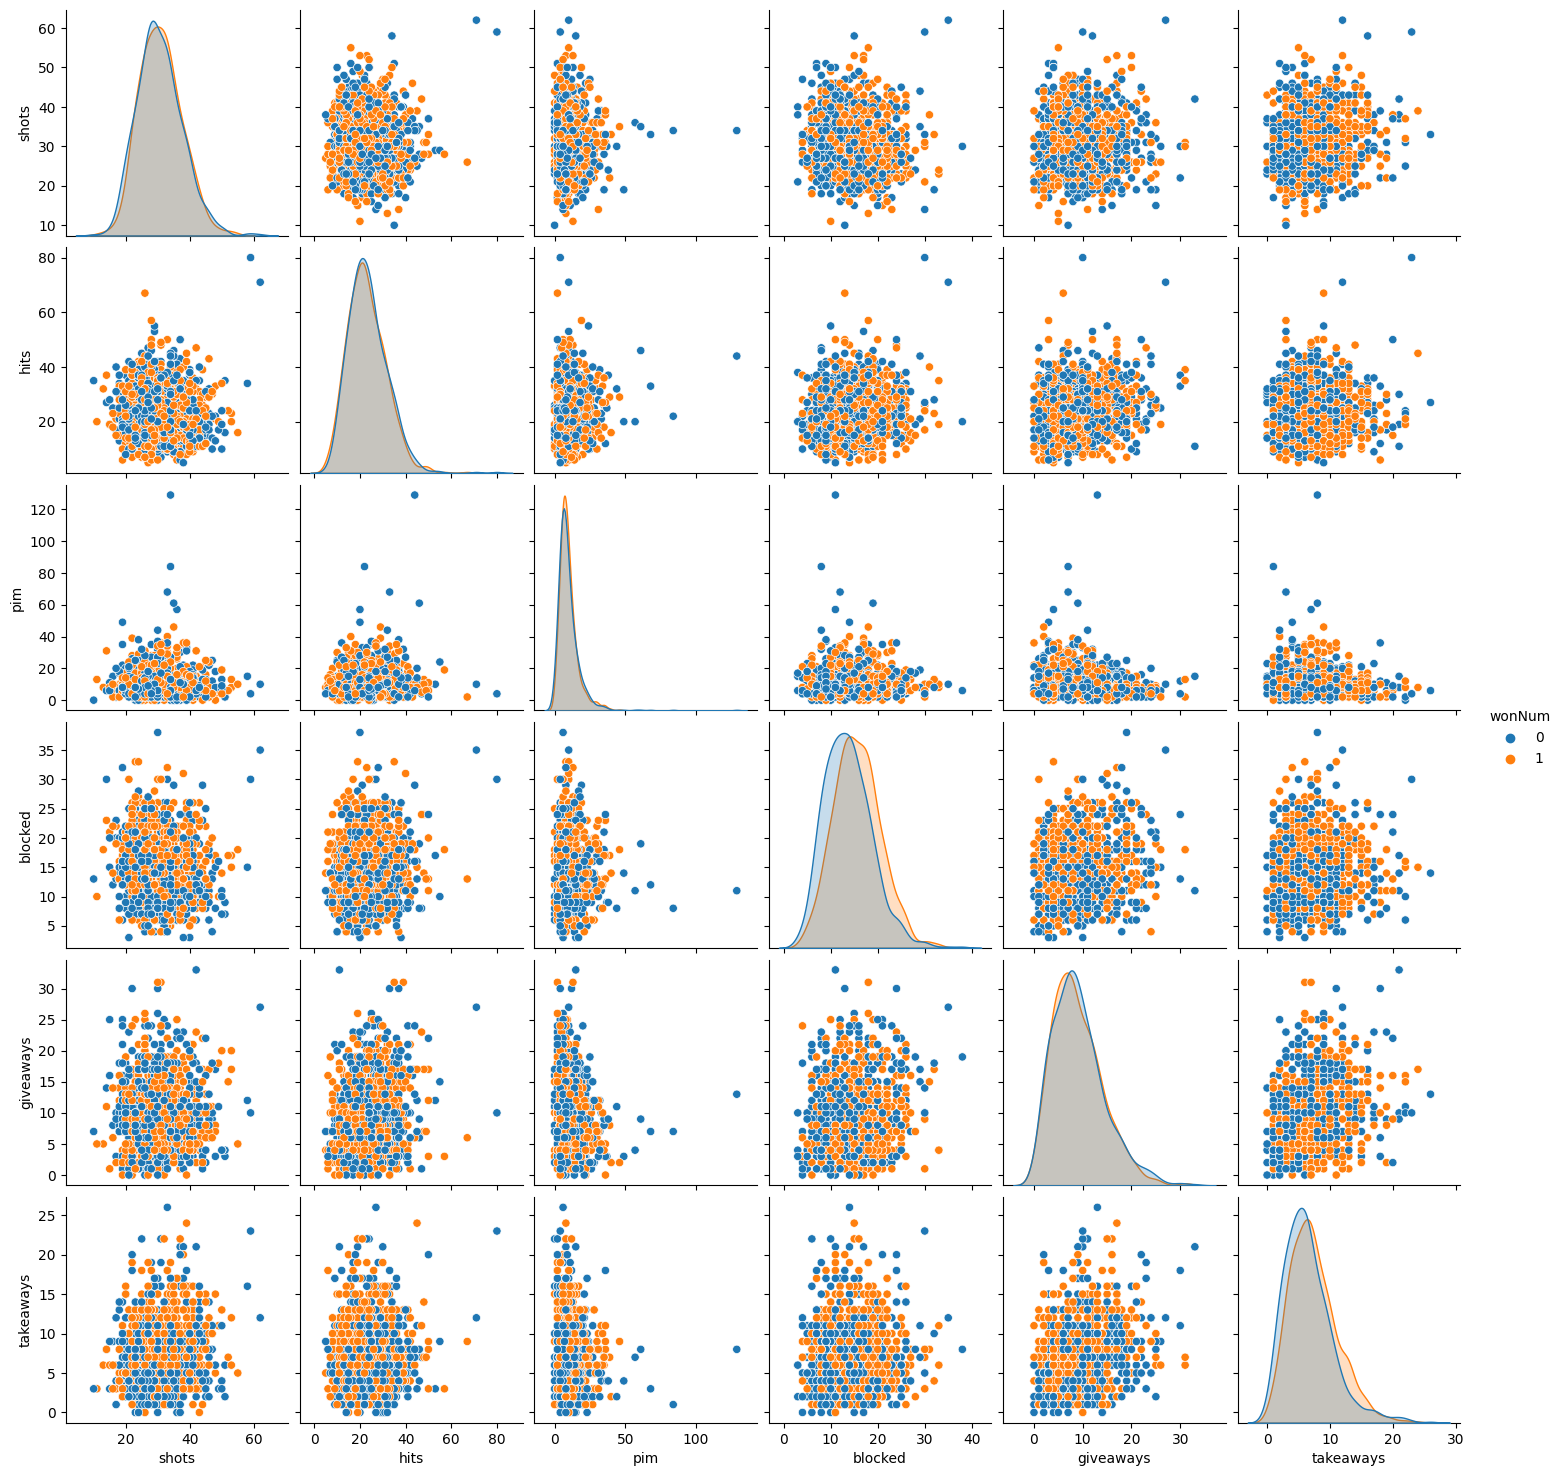

In [8]:
import seaborn as sns
sns.pairplot(df[['shots','hits', 'pim', 'blocked', 'giveaways', 'takeaways', 'wonNum']].sample(1500), hue='wonNum')

The interesting aspects of the bar chart are how much blocked shots matter in the outcome and how shots in general have no effect. Goals had a significant impact, as expected. The second chart does not provide many insights, but it does look nice. 

## Logistic Regression

Now we will use train_test_split to create a logistic regression model for machine learning. We will use Logistic Regression because it is a binary value that we are after. 

In [9]:
# Define features
features = ['HoA_Num', 'goals', 'shots', 'hits', 'pim',
       'powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage',
       'giveaways', 'takeaways', 'blocked']


X_train, X_test, y_train, y_test = train_test_split(df[features], df['wonNum'], test_size=0.2, random_state=42)
log = LogisticRegression(max_iter=5000)
log.fit(X_train, y_train)

y_train_pred = log.predict(X_train)
y_test_pred = log.predict(X_test)

In [10]:
accuracy_score(y_test, y_test_pred), accuracy_score(y_train, y_train_pred)

(0.7893179950698439, 0.7885934996096479)

We checked the data to see if it was overfit and since the training accuracy is about the same as the testing accuracy, it seems that the data is not overfit. Next we will make a column with the predicted win value for each row.

In [11]:
df['log_pred'] = log.predict(df[features])

Here we use a scatter plot to visualize goals versus wins for the actual data and the predicted data

In [12]:
c = alt.Chart(df.sample(5000, random_state=27)).mark_circle(opacity=.8, stroke='orange', strokeWidth=2).encode(
    x='goals',
    y='wonNum',
    size=alt.Size('count()', scale=alt.Scale(range=[50, 2000])),  
    color=alt.value('orange')
).properties(
    width=400,
    height=300,
    title='Scatter Goals / Win Plot'
)

c2 = alt.Chart(df.sample(5000, random_state=27)).mark_circle(opacity=.3, stroke='blue', strokeWidth=2).encode(
    x='goals',
    y='log_pred',
    size=alt.Size('count()', scale=alt.Scale(range=[50, 2000])),  
    color=alt.value('blue')
).properties(
    width=400,
    height=300,
    title='Scatter Goals / Win plot'
)

c + c2

alt.LayerChart(...)

We can see that the predicted data 'cares' more about goals then the real life data. I think this is because it has such a huge correlation compared to the other statistics that the model relied on it heavily.

## Random Forest Classifier

Now we will switch strategies to use a random forest classifier to see if we gain any insights. Also we do a quick check to see if the data is overfit. 

In [13]:
from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier(n_estimators=100, max_leaf_nodes=8)
rfr.fit(X_train, y_train)

rfr_train_pred = rfr.predict(X_train)
rfr_test_pred = rfr.predict(X_test)

accuracy_score(y_train, rfr_train_pred), accuracy_score(y_test, rfr_test_pred)

(0.7743353741217077, 0.7788003286770748)

Here once again I utilized chatgpt. This time I asked it to make a chart to visualize a random forest classifier model and it came up with this. 

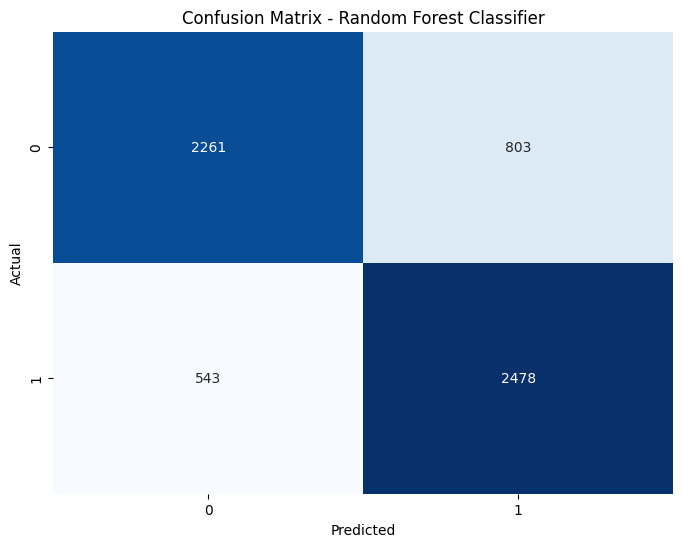

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = rfr.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

The chart is interesting because it shows that the model has a slight preference to predict a win. Now lets see what the model used to make these predictions 

In [15]:
pd.Series(rfr.feature_importances_, 
index=rfr.feature_names_in_).sort_values(ascending=False)

goals                     0.785496
powerPlayGoals            0.106497
blocked                   0.069151
takeaways                 0.015564
HoA_Num                   0.008875
powerPlayOpportunities    0.004994
hits                      0.004850
pim                       0.002741
shots                     0.001426
faceOffWinPercentage      0.000297
giveaways                 0.000110
dtype: float64

It relied heavily on goals as expected so lets take goals out of the features and see how it performs then

In [16]:
features2 = ['HoA_Num','shots', 'hits', 'pim',
       'powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage',
       'giveaways', 'takeaways', 'blocked']


In [17]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df[features2], df['wonNum'], test_size=0.2, random_state=42)
rfr2 = RandomForestClassifier(n_estimators=100, max_leaf_nodes=8)
rfr2.fit(X2_train, y2_train)

rfr2_train_pred = rfr2.predict(X2_train)
rfr2_test_pred = rfr2.predict(X2_test)

accuracy_score(y2_train, rfr2_train_pred), accuracy_score(y2_test, rfr2_test_pred)

(0.6350823848461191, 0.6315529991783073)

In [18]:
pd.Series(rfr2.feature_importances_, 
index=rfr2.feature_names_in_).sort_values(ascending=False)

powerPlayGoals            0.409233
blocked                   0.379723
takeaways                 0.098794
HoA_Num                   0.051410
hits                      0.030080
powerPlayOpportunities    0.015988
pim                       0.010887
giveaways                 0.001456
faceOffWinPercentage      0.001413
shots                     0.001016
dtype: float64

The model significantly worse without the help of goals. Also, the stat it relied on heavily still involved goals. Interestingly, blocked shots was a close second, which is something we noticed had a correlation in the beginning of our analysis.  It is still hard to believe how little the amount of shots impact whether or not a team wins.

## Summary

We looked at stats from a hockey game to see if we could determine the outcome of a game using the stats. Goals was a stat that is crucial to the outcome of a game but I think a couple surprises were that blocked shots have a strong impact and that shots had little to no impact. Perhaps teams should value players that block a lot of shots.

## References

Your code above should include references.  Here is some additional space for references.

* What is the source of your dataset(s)?

https://www.kaggle.com/datasets/martinellis/nhl-game-data?select=game_teams_stats.csv

* List any other references that you found helpful.
https://chat.openai.com/

https://deepnote.com/workspace/math-10-s23-4c3e19b5-0ebd-42cc-a839-5174247cc7dd/project/Week-6-Friday-b559614f-4726-4308-bf4a-e61e00123e29/notebook/Lecture%209-631d39590def4c749b49f9f9359f79ba

## Submission

Using the Share button at the top right, **enable Comment privileges** for anyone with a link to the project. Then submit that link on Canvas.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=150532f7-eb19-4b81-abd7-63da9fa04db2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>